In [ ]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from loguru import logger

In [71]:
import quasibi
importlib.reload(quasibi);

In [74]:
ys = np.random.random(size=(15, 400))
ys[2, 40] = np.nan
ys[2] = ys[4]
ys[3] = -ys[9]
ys[6] = 0.5*ys[0] + ys[7]

2023-03-21 16:17:36.935 | INFO     | quasibi:correlation_matrix:112 - Network with 15 nodes can have 105.0 possible links
2023-03-21 16:17:36.942 | INFO     | quasibi:correlation_matrix:113 - Using significance interval [0.025, 0.975) based on 10 surrogates
2023-03-21 16:17:36.946 | WARNING  | quasibi:correlation_matrix:114 - Calculating correlation matrix, get a cup of coffee...
100%|██████████| 105/105.0 [00:08<00:00, 12.71it/s]


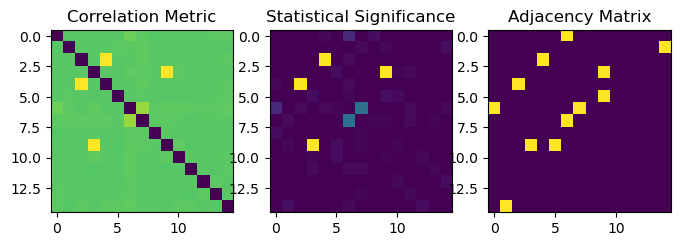

CPU times: user 8.06 s, sys: 214 ms, total: 8.28 s
Wall time: 8.58 s


In [76]:
%%time

C, S = quasibi.correlation_matrix(ys, metric=quasibi.rmd)
A = quasibi.adjacency_matrix(C, S)

plt.figure(figsize=(8, 3))
ax = plt.subplot(131)
ax.imshow(C)
ax.set_title("Correlation Metric")
ax = plt.subplot(132)
ax.imshow(S)
ax.set_title("Statistical Significance")
ax = plt.subplot(133)
ax.imshow(A)
ax.set_title("Adjacency Matrix")
plt.show()

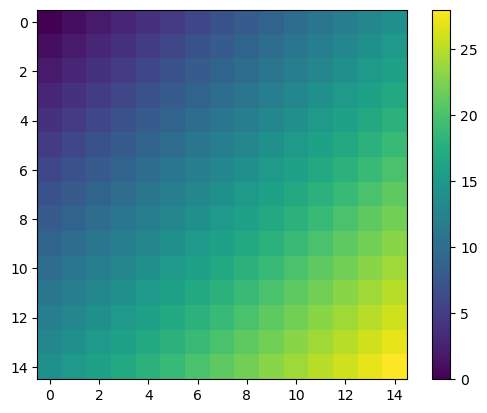

In [46]:
D = np.fromfunction(lambda i, j: i + j, (15, 15))
plt.imshow(D)
plt.colorbar()
plt.show()

2023-03-21 16:03:21.154 | INFO     | quasibi:create_surrogate_adjacency_matrix:224 - Calculated link lengths for 6 links
2023-03-21 16:03:21.163 | INFO     | quasibi:create_surrogate_adjacency_matrix:237 - Calculated seen and possible distributions in the interval [6.28, 16.73)
2023-03-21 16:03:21.166 | INFO     | quasibi:create_surrogate_adjacency_matrix:245 - Generating surrogates, drink a cup of tea...
100%|██████████| 105/105.0 [00:00<00:00, 14016.61it/s]


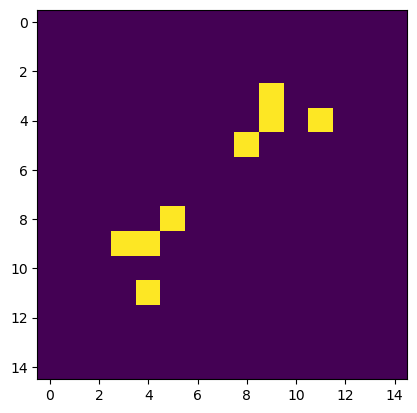

In [73]:
surrogates = quasibi.create_surrogate_adjacency_matrix(A, D, n_surrogates=1, bins=20)
plt.imshow(surrogates)